In [ ]:
# !pip install pandas numpy scikit-learn matplotlib tensorflow

In [1]:
import pandas as pd
import numpy as np
import IPython
import IPython.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, Flatten
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

In [3]:
# 1. Load the dataset
data = pd.read_csv('./data/BrentOilPricesMerged.csv')

In [4]:
# 2. Preprocess the data
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [5]:
data.head()

,Price,neg_oil,neu_oil,pos_oil,compound_oil,neg_war,neu_war,pos_war,compound_war
Date,,,,,,,,,
2023-04-03,84.930000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-04,84.940002,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-05,84.989998,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-06,85.120003,0.000,0.000,0.000,0.0000,0.000,0.776,0.224,0.9866
2023-04-10,84.180000,0.086,0.816,0.098,0.9796,0.144,0.708,0.147,-0.1356


In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,271.0,82.667343,5.567707,71.839996,78.139999,82.739998,86.355000,96.550003
neg_oil,271.0,0.023033,0.024112,0.000000,0.000000,0.017500,0.038271,0.116000
neu_oil,271.0,0.496814,0.361231,0.000000,0.000000,0.604750,0.831000,0.960000
pos_oil,271.0,0.064340,0.055087,0.000000,0.000000,0.062000,0.100667,0.181000
compound_oil,271.0,0.378112,0.429797,-0.955900,0.000000,0.270900,0.950900,0.999900
neg_war,271.0,0.082097,0.071262,0.000000,0.013000,0.073000,0.132375,0.272500
neu_war,271.0,0.802173,0.128576,0.000000,0.773586,0.817200,0.854250,1.000000
pos_war,271.0,0.104691,0.065619,0.000000,0.066000,0.118000,0.139875,0.435000
compound_war,271.0,0.163507,0.595739,-0.999900,-0.357750,0.115525,0.701659,0.986600


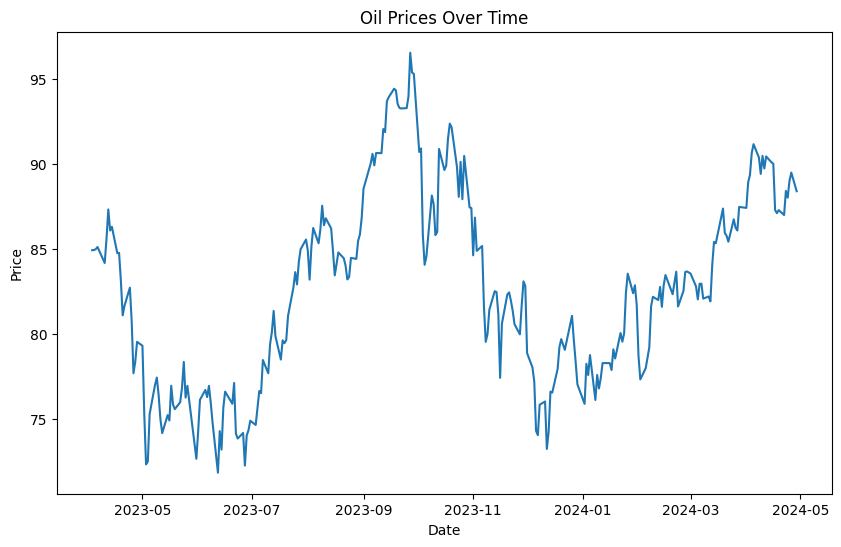

In [7]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Price'])
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [8]:
column_indices = {name: i for i, name in enumerate(data.columns)}
column_indices

{'Price': 0,
 'neg_oil': 1,
 'neu_oil': 2,
 'pos_oil': 3,
 'compound_oil': 4,
 'neg_war': 5,
 'neu_war': 6,
 'pos_war': 7,
 'compound_war': 8}

In [9]:
# Extract the relevant columns for oil sentiment data
# oil_data = data[['Price', 'neg_oil', 'neu_oil', 'pos_oil', 'compound_oil', 'neg_war', 'neu_war', 'pos_war', 'compound_war']]
oil_data = data[['Price']]
oil_data.head()

,Price
Date,
2023-04-03,84.930000
2023-04-04,84.940002
2023-04-05,84.989998
2023-04-06,85.120003
2023-04-10,84.180000


In [10]:
# Normalize the price data
scaler = MinMaxScaler(feature_range=(0, 1))
oil_data['Price'] = scaler.fit_transform(oil_data['Price'].values.reshape(-1, 1))
# oil_data = scaler.fit_transform(oil_data)

C:\Users\wgras\AppData\Local\Temp\ipykernel_20444\1558082071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_data['Price'] = scaler.fit_transform(oil_data['Price'].values.reshape(-1, 1))


In [11]:
n = len(oil_data)
train_df = oil_data[0:int(n*0.7)]
val_df = oil_data[int(n*0.7):int(n*0.875)]
test_df = oil_data[int(n*0.875):]

In [12]:
# train = 70%
# validation = 17.5%
# test - 12.5%

In [13]:
test_df

,Price
Date,
2024-03-12,0.407932
2024-03-13,0.493323
2024-03-14,0.549575
2024-03-15,0.546337
2024-03-18,0.609065
2024-03-19,0.628895
2024-03-20,0.571024
2024-03-21,0.564144
2024-03-22,0.549980


In [14]:
len(train_df),len(val_df),len(test_df)

(189, 48, 34)

In [15]:
train_df.columns

Index(['Price'], dtype='object')

In [16]:
#from tensrflow documentation
# https://www.tensorflow.org/tutorials/structured_data/time_series

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [17]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [18]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [19]:
def plot(self, model=None, plot_col='Price', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [20]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [21]:
# model architectures - LSTM,XGBoost, 1d cnn, transformers, ensemble
# model size (layers)
# sequence window length - 7 , 14, 30
# data - oil price only , oil price + reddit oil , oil price + reddit war, oil price + reddit oil,war  

In [22]:
val_performance = {}
performance = {}
histories={}
models_list={}
windows_list={}

windows_dictionary = {
    'weekly': 7, 
    'bi-weekly': 14, 
    'monthly': 30,       
}


In [23]:
for w in windows_dictionary:
    input_width=windows_dictionary[w]
    window = WindowGenerator(
        input_width=input_width, label_width=1, shift=1,
        label_columns=['Price']
    )
    windows_list[w]=window


In [24]:
windows_list

{'weekly': Total window size: 8
 Input indices: [0 1 2 3 4 5 6]
 Label indices: [7]
 Label column name(s): ['Price'],
 'bi-weekly': Total window size: 15
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 Label indices: [14]
 Label column name(s): ['Price'],
 'monthly': Total window size: 31
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29]
 Label indices: [30]
 Label column name(s): ['Price']}

In [25]:
windows_list['monthly']

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [26]:
MAX_EPOCHS = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)

def compile_and_fit(model, window, patience=4):
  model.compile(
    loss='mean_absolute_percentage_error',
    optimizer='adam',
    metrics=[
      tf.keras.metrics.MeanAbsolutePercentageError(),
      tf.keras.metrics.MeanSquaredError()
    ]
  )

  history = model.fit(
    window.train, 
    epochs=MAX_EPOCHS, 
    validation_data=window.val,
    callbacks=[early_stopping,reduce_lr]
  )

  return history

1. Linear model

In [27]:
train_df.shape

(189, 1)

In [28]:
window=windows_list['monthly']
seq_length=30
input_shape=(seq_length, train_df.shape[1])
window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [29]:
input_shape

(30, 1)

In [30]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=input_shape)
])

# linear=get_ensemble_model2(input_shape)

In [31]:
history = compile_and_fit(linear, window)

histories_Linear = history
val_performance_Linear = linear.evaluate(window.val, return_dict=True)
performance_Linear = linear.evaluate(window.test, verbose=1, return_dict=True)

Epoch 1/100
5/5 [==============================] - 2s 138ms/step - loss: 1334543.8750 - mean_absolute_percentage_error: 1334544.0000 - mean_squared_error: 0.0915 - val_loss: 26.1868 - val_mean_absolute_percentage_error: 26.1868 - val_mean_squared_error: 0.0162 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 31ms/step - loss: 1320921.6250 - mean_absolute_percentage_error: 1320921.6250 - mean_squared_error: 0.0900 - val_loss: 25.9917 - val_mean_absolute_percentage_error: 25.9917 - val_mean_squared_error: 0.0159 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 0s 33ms/step - loss: 1306535.1250 - mean_absolute_percentage_error: 1306535.2500 - mean_squared_error: 0.0888 - val_loss: 25.7909 - val_mean_absolute_percentage_error: 25.7909 - val_mean_squared_error: 0.0156 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 0s 33ms/step - loss: 1291881.7500 - mean_absolute_percentage_error: 1291881.8750 - mean_squared_error: 0.0877 - val_loss: 25.5947

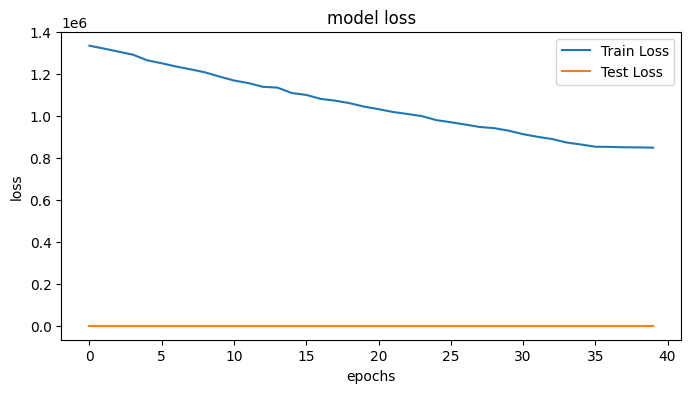

In [32]:
# Plot Train vs Test Loss
plt.figure(figsize=(8,4))
plt.plot(histories_Linear.history['loss'], label='Train Loss')
plt.plot(histories_Linear.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
# plt.savefig('outputs/reddit oil + war - lstm model 01 model loss.png')
plt.show()

In [33]:
def get_linear_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=1, input_shape=input_shape)
    ])
    
    return model

In [34]:
def get_dense_model(input_shape):
    input = keras.Input(shape=input_shape)

    layer_1 = Dense(units=64, activation='relu')(input)
    layer_2 = Dense(units=32, activation='relu')(layer_1)
    layer_3 = Dense(units=8, activation='relu')(layer_2)
    output = Dense(units=1, activation='relu')(layer_3)

    model=keras.Model(input, output)

    return model


In [35]:

def get_conv_model(input_shape):
    input = keras.Input(shape=input_shape)

    layer_1 = Conv1D(
        filters=32,
        kernel_size=input_shape[0],
        activation='relu',
        padding='same')(input)
    layer_1 = layers.MaxPooling1D()(layer_1)
    layer_1 = Flatten()(layer_1)
    layer_2 = Dense(units=32, activation='relu')(layer_1)
    layer_3 = Dense(units=8, activation='relu')(layer_2)
    output = Dense(units=1, activation='relu')(layer_3)

    model=keras.Model(input, output)

    return model

    # model = tf.keras.Sequential([
    #     tf.keras.layers.Conv1D(filters=32,
    #                         kernel_size=(input_shape[0],),
    #                         activation='relu'),
    #     tf.keras.layers.Dense(units=32, activation='relu'),
    #     tf.keras.layers.Dense(units=1),
    # ])

In [36]:

def get_lstm_model_1(input_shape):
    # 3. Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    return model

In [37]:

def get_lstm_model_2(input_shape):
    model = Sequential()
    model.add(LSTM(units=60, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(LSTM(units=60, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=60, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(units=1))

    return model

In [38]:

def get_lstm_model_3(input_shape):
    input = keras.Input(shape=input_shape)

    layer = LSTM(units=60, return_sequences=True)(input)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=50, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=40, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=30, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=30, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=20, return_sequences=False)(layer)
    layer = Dropout(0.2)(layer)
    output = Dense(units=1)(layer)

    model=keras.Model(input, output)

    # model = Sequential()
    # model.add(LSTM(units=60, return_sequences=True, input_shape=input_shape))
    # model.add(Dropout(0.2))
    # model.add(LSTM(units=50, return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(LSTM(units=40, return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(LSTM(units=30, return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(LSTM(units=20, return_sequences=False))
    # model.add(Dropout(0.2))
    # model.add(Dense(units=1))

    return model

In [39]:

def get_bidirectional_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=20, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units=20, return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units=10, return_sequences=False)))
    model.add(Dropout(0.1))
    model.add(Dense(units=1))

    return model

In [40]:
# 3. Build the Transformer model
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
d_model = 64
num_heads = 4
ff_dim = 64
num_transformer_blocks = 4
rate = 0.1

def build_transformer_model(seq_length, d_model, num_heads, ff_dim, num_transformer_blocks, rate=0.1):
    inputs = Input(shape=(seq_length, 1))
    x = Dense(d_model)(inputs)

    for _ in range(num_transformer_blocks):
        x = TransformerBlock(d_model, num_heads, ff_dim, rate)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(rate)(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

def get_transformer_model(input_shape):
    model = build_transformer_model(
    input_shape[0], 
    d_model, 
    num_heads, 
    ff_dim, 
    num_transformer_blocks,
    rate
)

    return model

In [41]:
def get_ensemble_model(input_shape):
    model1 = get_dense_model(input_shape)
    model2 = get_dense_model(input_shape)
    model3 = get_dense_model(input_shape)

    inputs = keras.Input(shape=input_shape)
    y1 = model1(inputs)
    y2 = model2(inputs)
    y3 = model3(inputs)
    outputs = layers.average([y1, y2, y3])
    ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
    return ensemble_model

In [42]:
def get_ensemble_model2(input_shape):
    inputs = keras.Input(shape=input_shape)
    
    transformer_model = get_transformer_model(input_shape)
    lstm_model = get_lstm_model_3(input_shape)
    convolution_model = get_conv_model(input_shape)

    y1 = transformer_model(inputs)
    y2 = lstm_model(inputs)
    y3 = convolution_model(inputs)
    
    ensemble_model=layers.concatenate([y1, y2, y3])
    layer_1 = Dense(units=64, activation='relu')(ensemble_model)
    layer_2 = Dense(units=32, activation='relu')(layer_1)
    layer_3 = Dense(units=8, activation='relu')(layer_2)
    outputs = Dense(units=1, activation='relu')(layer_3)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [43]:
models_name_list={
    'linear_model' : get_linear_model ,
    'dense_model' : get_dense_model ,
    'conv_model' : get_conv_model ,
    'lstm_model_1' : get_lstm_model_1 ,
    'lstm_model_2' : get_lstm_model_2 ,
    'lstm_model_3' : get_lstm_model_3 ,
    'bidirectional_lstm_model' : get_bidirectional_lstm_model ,
    'transformer_model' : get_transformer_model ,
    'ensemble_model' : get_ensemble_model ,
    'ensemble_model_2' : get_ensemble_model2 ,
}
models_list={}

In [44]:
for model_type in models_name_list:
    print(model_type)

linear_model
dense_model
conv_model
lstm_model_1
lstm_model_2
lstm_model_3
bidirectional_lstm_model
transformer_model
ensemble_model
ensemble_model_2


In [45]:
def create_model_for_each_model_type(model_type):
    for window_name in windows_dictionary:
        seq_length=windows_dictionary[window_name]
        window = windows_list[window_name]
        input_shape=(seq_length, train_df.shape[1])


        model_name=f'{model_type}_{window_name}'
        print('\n\n\n--------------',model_name, input_shape, '--------------')
        model = models_name_list[model_type](input_shape)
        print(model.summary())
        
        models_list[model_name]= {
            'model':model,
            'window':window
        }


In [46]:
for model_type in models_name_list:
    print('\n------------',model_type,'------------')
    create_model_for_each_model_type(model_type)


------------ linear_model ------------



-------------- linear_model_weekly (7, 1) --------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 7, 1)              2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None



-------------- linear_model_bi-weekly (14, 1) --------------
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 14, 1)             2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_

In [47]:
tf.__version__

'2.13.1'

In [48]:
models_list

{'linear_model_weekly': {'model': <keras.src.engine.sequential.Sequential at 0x14b00a8fd10>,
  'window': Total window size: 8
  Input indices: [0 1 2 3 4 5 6]
  Label indices: [7]
  Label column name(s): ['Price']},
 'linear_model_bi-weekly': {'model': <keras.src.engine.sequential.Sequential at 0x14b00a56cd0>,
  'window': Total window size: 15
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
  Label indices: [14]
  Label column name(s): ['Price']},
 'linear_model_monthly': {'model': <keras.src.engine.sequential.Sequential at 0x14b00a47d10>,
  'window': Total window size: 31
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
   24 25 26 27 28 29]
  Label indices: [30]
  Label column name(s): ['Price']},
 'dense_model_weekly': {'model': <keras.src.engine.functional.Functional at 0x14b00a1f710>,
  'window': Total window size: 8
  Input indices: [0 1 2 3 4 5 6]
  Label indices: [7]
  Label column name(s): ['Price']},
 'dense_model_bi-weekl

In [49]:
len(models_list)

30

In [50]:
models_list['linear_model_weekly']

{'model': <keras.src.engine.sequential.Sequential at 0x14b00a8fd10>,
 'window': Total window size: 8
 Input indices: [0 1 2 3 4 5 6]
 Label indices: [7]
 Label column name(s): ['Price']}

In [51]:
model_name='linear_model_monthly' 
model = models_list[model_name]['model']
window = models_list[model_name]['window']
window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [52]:
for model_name in models_list:
    model = models_list[model_name]['model']
    window = models_list[model_name]['window']
    
    print('\n\n\n------------',model_name,'------------')
    history = compile_and_fit(model, window)

    histories[model_name] = history
    print('------------val performance')
    val_performance[model_name] = model.evaluate(window.val, return_dict=True)
    print('------------test performance')
    performance[model_name] = model.evaluate(window.test, verbose=1, return_dict=True)




------------ linear_model_weekly ------------
Epoch 1/100
6/6 [==============================] - 1s 50ms/step - loss: 923061.1875 - mean_absolute_percentage_error: 923061.0625 - mean_squared_error: 0.9609 - val_loss: 198.9292 - val_mean_absolute_percentage_error: 198.9292 - val_mean_squared_error: 0.5925 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 20ms/step - loss: 900433.3125 - mean_absolute_percentage_error: 900433.2500 - mean_squared_error: 0.9543 - val_loss: 198.2165 - val_mean_absolute_percentage_error: 198.2165 - val_mean_squared_error: 0.5886 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 21ms/step - loss: 884523.2500 - mean_absolute_percentage_error: 884523.3125 - mean_squared_error: 0.9490 - val_loss: 197.4288 - val_mean_absolute_percentage_error: 197.4288 - val_mean_squared_error: 0.5842 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 20ms/step - loss: 868571.3125 - mean_absolute_percentage_error: 868571.3125 - 

## evaluate

In [ ]:
histories

In [ ]:
# for h in histories:    # Plot Train vs Test Loss
#     history=histories[h]
#     plt.figure(figsize=(8,4))
#     plt.plot(history.history['loss'], label='Train Loss')
#     plt.plot(history.history['val_loss'], label='Test Loss')
#     plt.title(f'{h} model loss')
#     plt.ylabel('loss')
#     plt.xlabel('epochs')
#     plt.legend(loc='upper right')
#     plt.savefig(f'outputs2/model loss {h} oil price only.png')
#     plt.show()

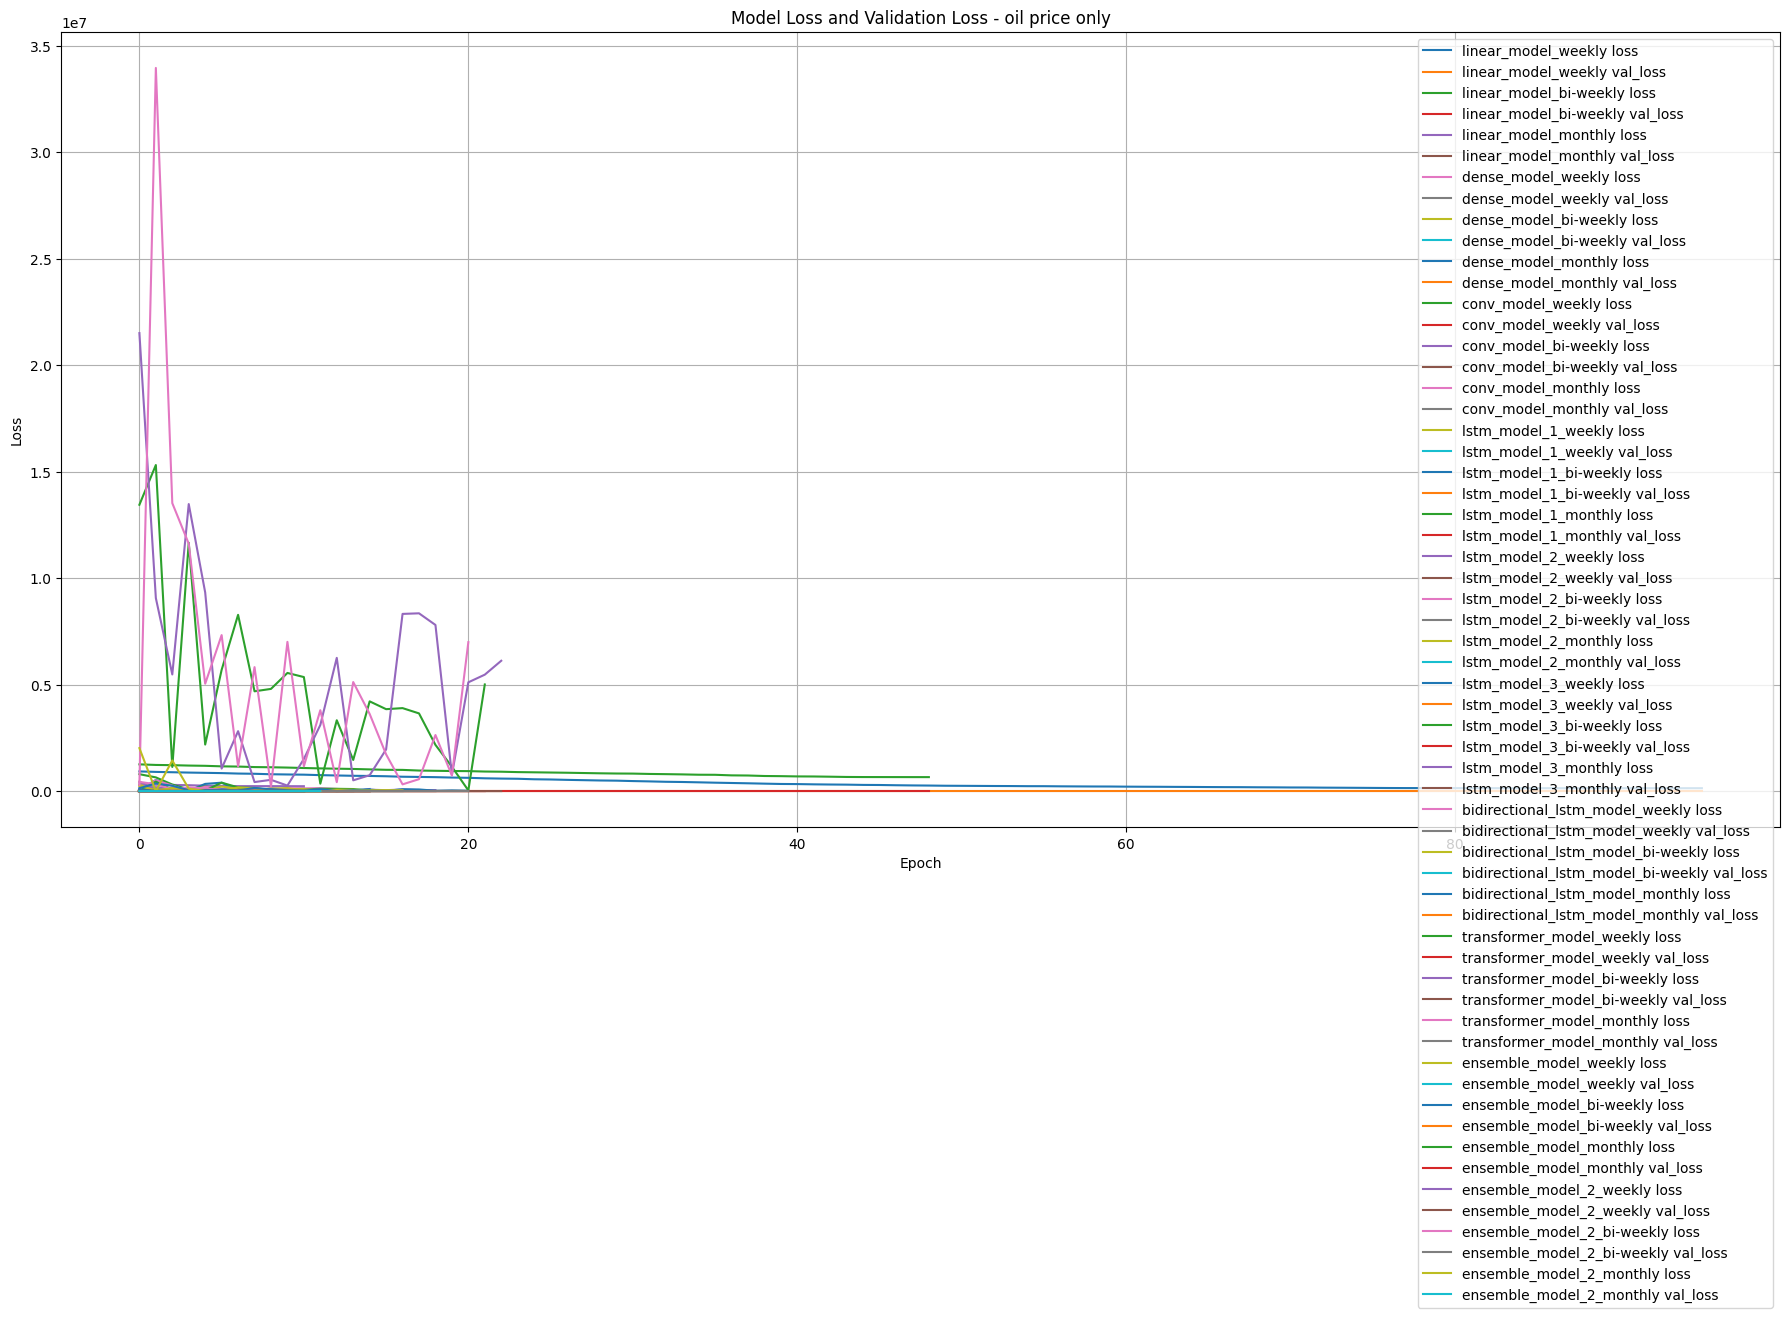

In [53]:
plt.figure(figsize=(18, 12))
for h in (histories):    # Plot Train vs Test Loss
    history=histories[h]
    plt.plot(history.history['loss'], label=f'{h} loss')
    plt.plot(history.history['val_loss'], label=f'{h} val_loss')

plt.title('Model Loss and Validation Loss - oil price only')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs2/model loss all models oil price only.png')

In [54]:
val_performance

{'linear_model_weekly': {'loss': 141.98828125,
  'mean_absolute_percentage_error': 141.98829650878906,
  'mean_squared_error': 0.31835490465164185},
 'linear_model_bi-weekly': {'loss': 23.876829147338867,
  'mean_absolute_percentage_error': 23.876829147338867,
  'mean_squared_error': 0.014299155212938786},
 'linear_model_monthly': {'loss': 74.26500701904297,
  'mean_absolute_percentage_error': 74.26500701904297,
  'mean_squared_error': 0.11065057665109634},
 'dense_model_weekly': {'loss': 100.0,
  'mean_absolute_percentage_error': 100.0,
  'mean_squared_error': 0.15339039266109467},
 'dense_model_bi-weekly': {'loss': 100.0,
  'mean_absolute_percentage_error': 100.0,
  'mean_squared_error': 0.16974203288555145},
 'dense_model_monthly': {'loss': 100.0,
  'mean_absolute_percentage_error': 100.0,
  'mean_squared_error': 0.19805388152599335},
 'conv_model_weekly': {'loss': 100.0,
  'mean_absolute_percentage_error': 100.0,
  'mean_squared_error': 0.15339037775993347},
 'conv_model_bi-weekly'

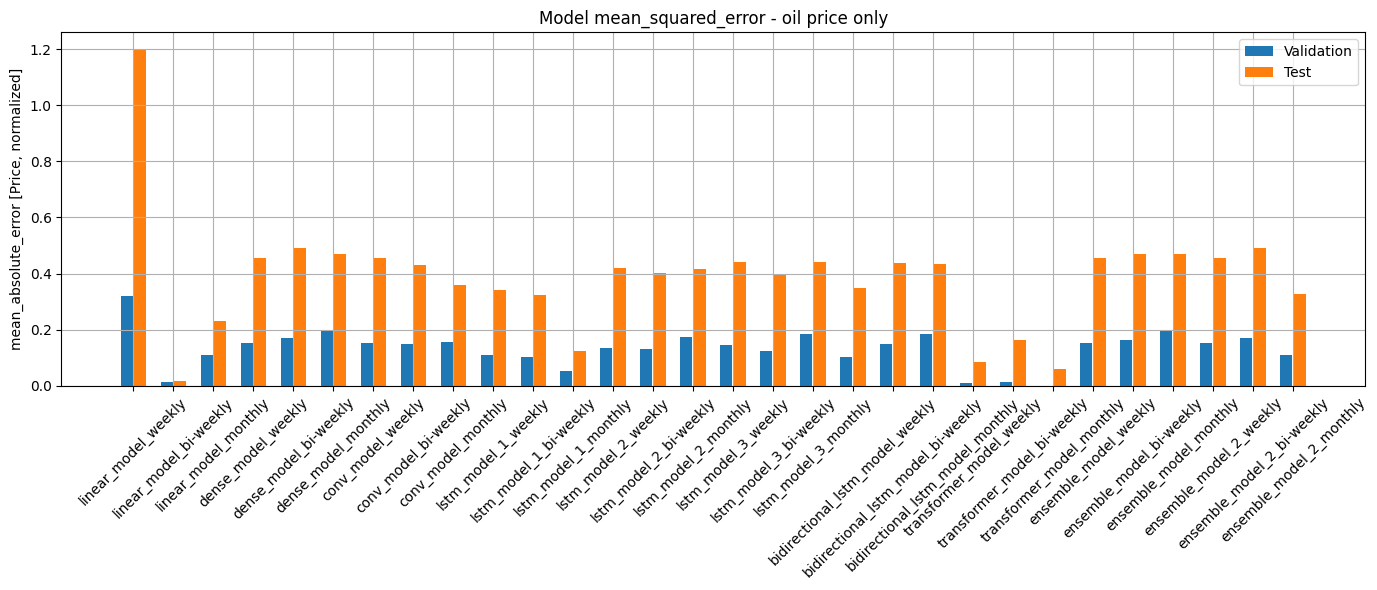

In [55]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.figure(figsize=(14, 6))
plt.title('Model mean_squared_error - oil price only')
plt.ylabel('mean_absolute_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs2/mean_squared_error all models oil price only.png')


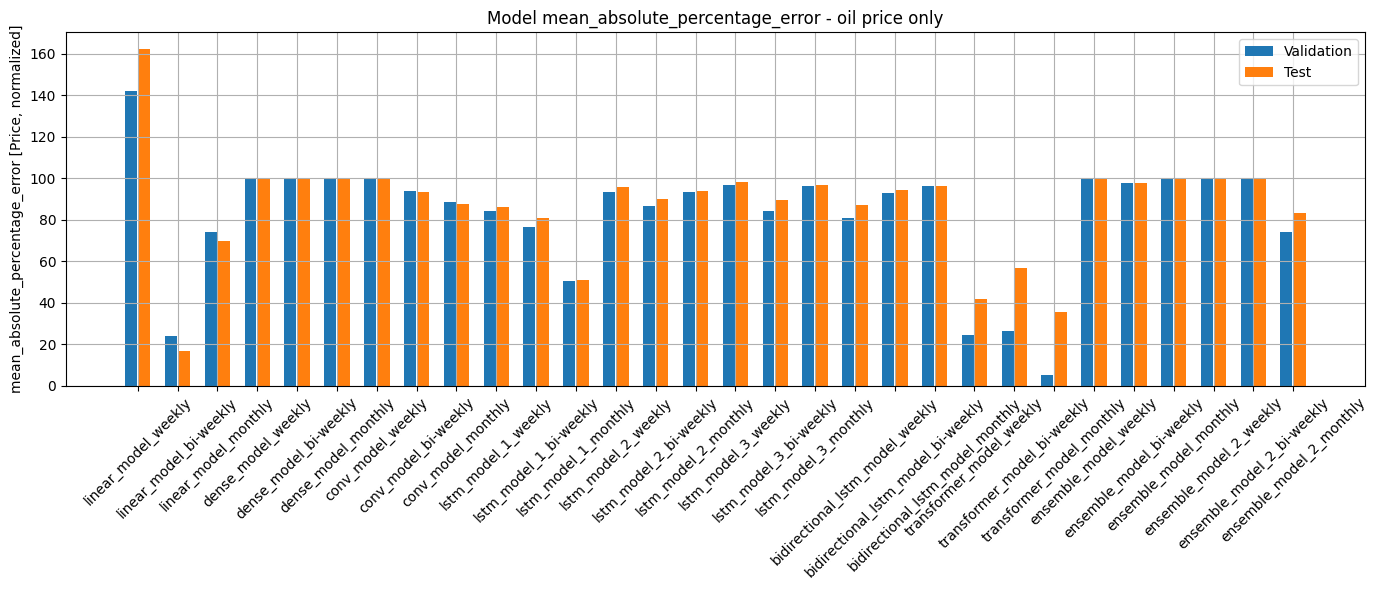

In [56]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_percentage_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]
plt.figure(figsize=(14, 6))
plt.title('Model mean_absolute_percentage_error - oil price only')
plt.ylabel('mean_absolute_percentage_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs2/mean_absolute_percentage_error all models oil price only.png')

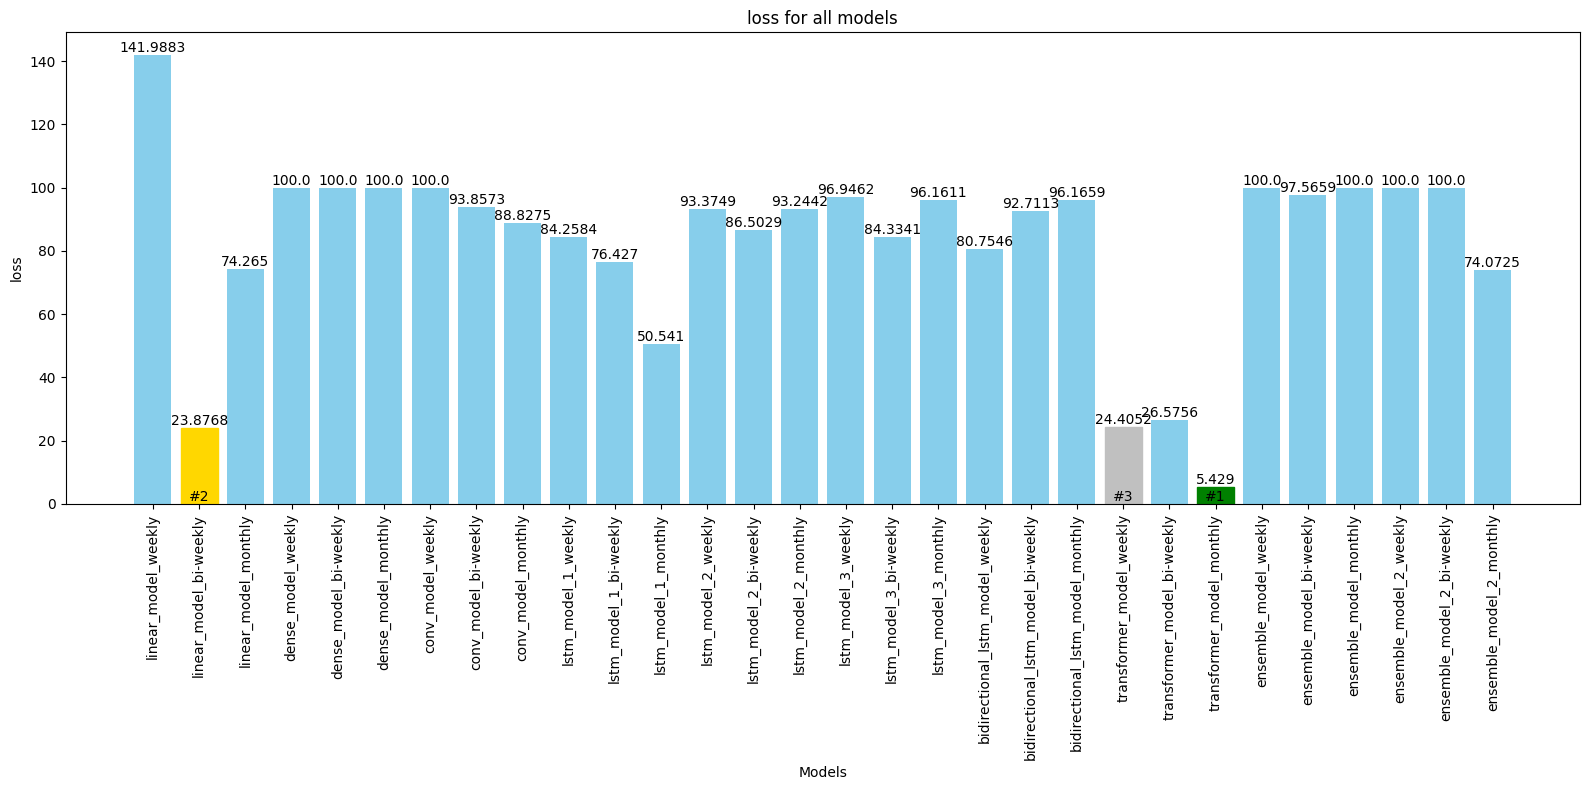

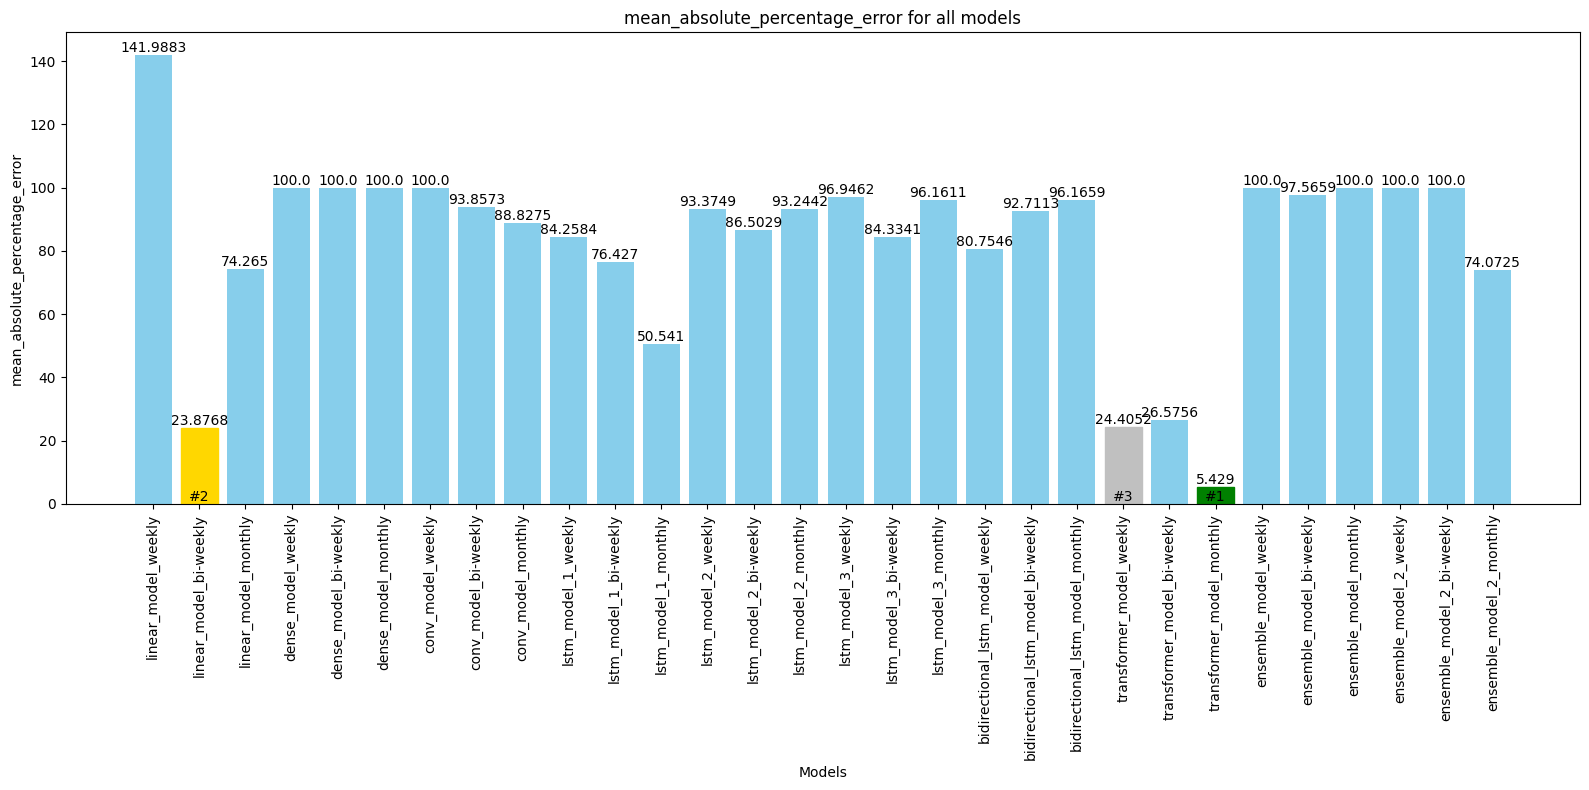

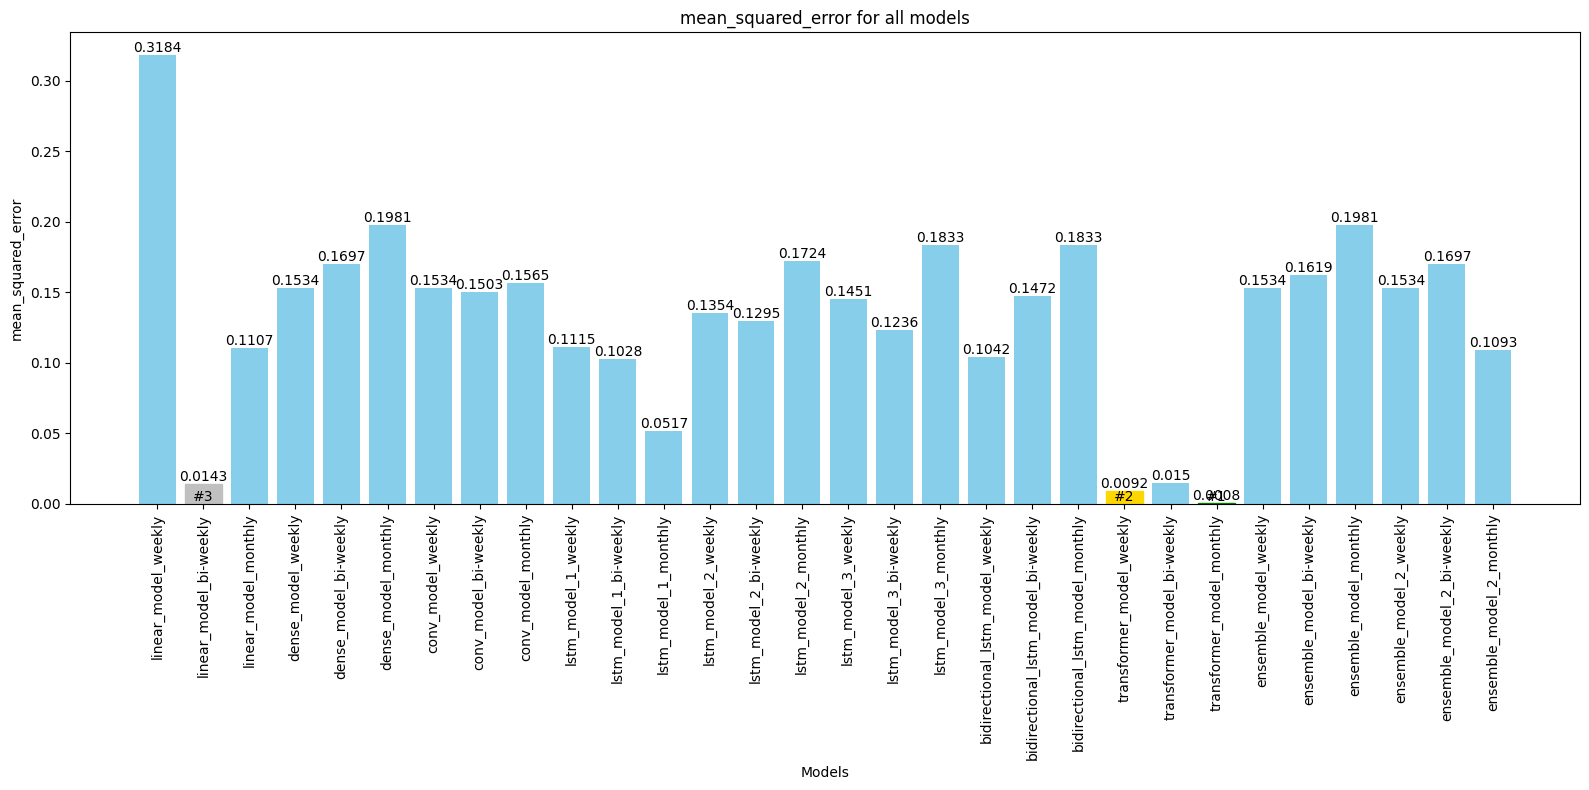

Top 3 models with minimum loss: ['transformer_model_monthly', 'linear_model_bi-weekly', 'transformer_model_weekly']
Top 3 models with minimum mean_absolute_error: ['transformer_model_monthly', 'linear_model_bi-weekly', 'transformer_model_weekly']
Top 3 models with minimum mean_squared_error: ['transformer_model_monthly', 'transformer_model_weekly', 'linear_model_bi-weekly']


In [57]:
# Extract data for each metric
models = list(val_performance.keys())
loss_values = [val_performance[model]['loss'] for model in models]
mae_values = [val_performance[model]['mean_absolute_percentage_error'] for model in models]
mse_values = [val_performance[model]['mean_squared_error'] for model in models]

# Function to plot and save a metric, highlighting the best model
def plot_and_save_metric(metric_values, metric_name, best_models_indices):
    plt.figure(figsize=(16, 8))
    bars = plt.bar(models, metric_values, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for all models')
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Highlight the best models with different colors
    colors = ['green', 'gold', 'silver']
    for rank, index in enumerate(best_models_indices):
        bars[index].set_color(colors[rank])
        yval = bars[index].get_height()

        plt.text(bars[index].get_x() + bars[index].get_width()/2,  0, f'#{rank+1}', ha='center', va='bottom')

    # Annotate all bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

    plt.savefig(f'outputs2/{metric_name}_comparison.png')
    plt.show()

# Find the indices of the top 3 models with the minimum values for each metric
top_n = 3

min_loss_indices = np.argsort(loss_values)[:top_n]
min_mae_indices = np.argsort(mae_values)[:top_n]
min_mse_indices = np.argsort(mse_values)[:top_n]
# Plot and save loss
plot_and_save_metric(loss_values, 'loss', min_loss_indices)

# Plot and save mean_absolute_error
plot_and_save_metric(mae_values, 'mean_absolute_percentage_error', min_mae_indices)

# Plot and save mean_squared_error
plot_and_save_metric(mse_values, 'mean_squared_error', min_mse_indices)

# Get the model names for the top 3 models
min_loss_models = [models[i] for i in min_loss_indices]
min_mae_models = [models[i] for i in min_mae_indices]
min_mse_models = [models[i] for i in min_mse_indices]

print(f'Top {top_n} models with minimum loss: {min_loss_models}')
print(f'Top {top_n} models with minimum mean_absolute_error: {min_mae_models}')
print(f'Top {top_n} models with minimum mean_squared_error: {min_mse_models}')